# Sales Analysis

#### EDA - import necessary libaries

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import re

In [2]:
pwd

'C:\\Users\\AKASAKOW\\Desktop\\Data Science\\SalesAnalysis'

In [3]:
# Read all 12 csv files into one dataframe
files = glob.glob("C:\\Users\\AKASAKOW\\Desktop\\Data Science\\SalesAnalysis\\Sales_Data\\*.csv")

df = pd.DataFrame()
for f in files:
    csv = pd.read_csv(f)
    df = df.append(csv)

In [4]:
df.head(5)

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,176558,USB-C Charging Cable,2,11.95,04/19/19 08:46,"917 1st St, Dallas, TX 75001"
1,NaN,NaN,NaN,NaN,NaN,NaN
2,176559,Bose SoundSport Headphones,1,99.99,04/07/19 22:30,"682 Chestnut St, Boston, MA 02215"
3,176560,Google Phone,1,600,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"
4,176560,Wired Headphones,1,11.99,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"


#### EDA - cleaning up data

##### Practice shows that most of the time Data Scientists spend more than 60% of their time in cleaning data and formatting to their desired needs to build and analyze models for the best outcome. So that's what we gonna do now!

In [5]:
df.shape # The dataset has in total 186850 entries/rows which are displayed by 6 columns

(186850, 6)

In [6]:
# Let's check how many missing values the dataset has
df.isna().sum()

Order ID            545
Product             545
Quantity Ordered    545
Price Each          545
Order Date          545
Purchase Address    545
dtype: int64

In [7]:
# With the dropna method we can delete the empty/missing values in our dataset
df.dropna(axis=0, how='any', inplace=True)

In [8]:
df.shape

(186305, 6)

In [9]:
df.isna().sum()

Order ID            0
Product             0
Quantity Ordered    0
Price Each          0
Order Date          0
Purchase Address    0
dtype: int64

In [10]:
# We have to make sure to convert each column to its appropriate data type.
# With the price or the quantity ordered as strings we cannot run mathematical operations
df.dtypes 

Order ID            object
Product             object
Quantity Ordered    object
Price Each          object
Order Date          object
Purchase Address    object
dtype: object

In [11]:
df = df[~df['Order ID'].astype(str).str.startswith('O')]

In [12]:
df['Price Each'] = df['Price Each'].astype(float)
df[['Order ID', 'Quantity Ordered']] = df[['Order ID', 'Quantity Ordered']].astype(int)
df['Order Date'] = pd.to_datetime(df['Order Date'])
df.dtypes

Order ID                     int32
Product                     object
Quantity Ordered             int32
Price Each                 float64
Order Date          datetime64[ns]
Purchase Address            object
dtype: object

In [13]:
df['month'] = df['Order Date'].dt.month

## Data Exploration

### Q1: Which was the best month according to sales numbers?

In [14]:
df['revenue'] = df['Quantity Ordered'] * df['Price Each']

In [15]:
monthly_arr = df.groupby('month').revenue.sum().astype(int)
monthly_arr

month
1     1822256
2     2202022
3     2807100
4     3390670
5     3152606
6     2577802
7     2647775
8     2244467
9     2097560
10    3736726
11    3199603
12    4613443
Name: revenue, dtype: int32

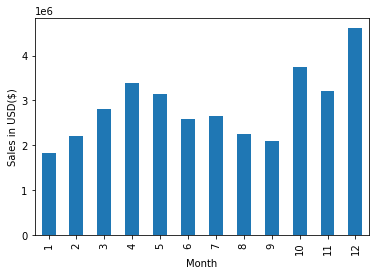

In [16]:
monthly_arr.plot(kind='bar')

plt.xlabel('Month')
plt.ylabel('Sales in USD($)')
plt.show()

### Q2: Which  city had the highest number of sales?

In [17]:
df['city'] = df['Purchase Address'].str.split(',').str[1]

In [18]:
city_arr = df.groupby('city').revenue.sum().astype(int).sort_values()

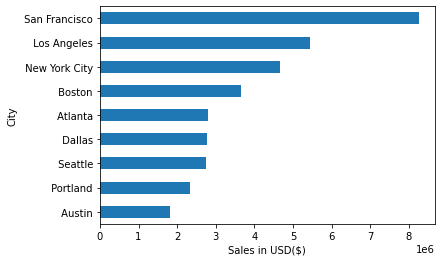

In [19]:
city_arr.plot(kind='barh')

plt.xlabel('Sales in USD($)')
plt.ylabel('City')
plt.show()

### Q3: What time should we place our ads to maximize likelihood of customer's buying product?

In [20]:
df['hour'] = df['Order Date'].dt.hour

In [21]:
hourly_arr = df.groupby('hour').revenue.sum()

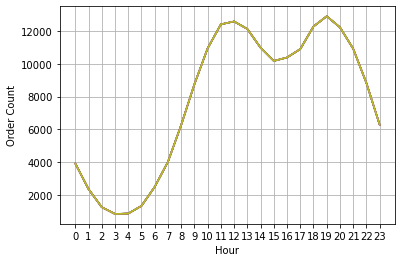

In [22]:
plt.plot([hour for hour, df in df.groupby('hour')], df.groupby('hour').count())

plt.xlabel('Hour')
plt.ylabel('Order Count')
plt.grid()
plt.xticks([hour for hour, df in df.groupby('hour')])
plt.show()

### Q4: What products are most often sold together?

In [23]:
df_duplicated = df[df['Order ID'].duplicated(keep=False)]

In [24]:
df_duplicated.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,month,revenue,city,hour
3,176560,Google Phone,1,600.00,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",4,600.00,Los Angeles,14
4,176560,Wired Headphones,1,11.99,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",4,11.99,Los Angeles,14
18,176574,Google Phone,1,600.00,2019-04-03 19:42:00,"20 Hill St, Los Angeles, CA 90001",4,600.00,Los Angeles,19
19,176574,USB-C Charging Cable,1,11.95,2019-04-03 19:42:00,"20 Hill St, Los Angeles, CA 90001",4,11.95,Los Angeles,19
30,176585,Bose SoundSport Headphones,1,99.99,2019-04-07 11:31:00,"823 Highland St, Boston, MA 02215",4,99.99,Boston,11


In [25]:
df_duplicated['grouped'] = df_duplicated.groupby('Order ID')['Product'].transform(lambda x: ', '.join(x))

<ipython-input-25-0d2fb2265986>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_duplicated['grouped'] = df_duplicated.groupby('Order ID')['Product'].transform(lambda x: ', '.join(x))


In [26]:
df_duplicated = df_duplicated[['Order ID', 'grouped']].drop_duplicates()

In [27]:
from itertools import combinations
from collections import Counter

count = Counter()

for row in df_duplicated['grouped']:
    rowlist = row.split(',')
    count.update(Counter(combinations(rowlist, 2)))

In [28]:
for key, value in count.most_common(10):
    print(f"{key} : {value}")

('iPhone', ' Lightning Charging Cable') : 1005
('Google Phone', ' USB-C Charging Cable') : 987
('iPhone', ' Wired Headphones') : 447
('Google Phone', ' Wired Headphones') : 414
('Vareebadd Phone', ' USB-C Charging Cable') : 361
('iPhone', ' Apple Airpods Headphones') : 360
('Google Phone', ' Bose SoundSport Headphones') : 220
('Vareebadd Phone', ' Wired Headphones') : 143
(' USB-C Charging Cable', ' Wired Headphones') : 120
('Vareebadd Phone', ' Bose SoundSport Headphones') : 80


### Q5: What product sold the most? Why do you think it sold the most?

In [29]:
products = df.groupby('Product')['Quantity Ordered'].sum()

In [30]:
# products.sort_values(inplace=True)

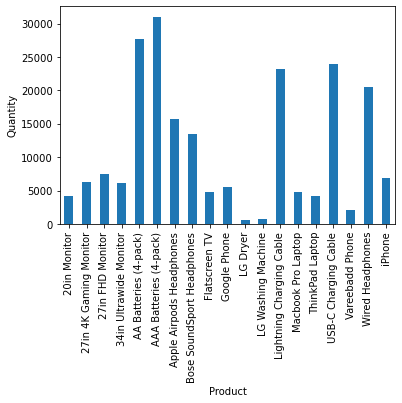

In [31]:
products.plot(kind='bar')

plt.xlabel('Product')
plt.ylabel('Quantity')
plt.show()

In [32]:
prices = df.groupby('Product').mean()['Price Each']

<ipython-input-33-791871e7a31e>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(keys, rotation=90, size=8)
<ipython-input-33-791871e7a31e>:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


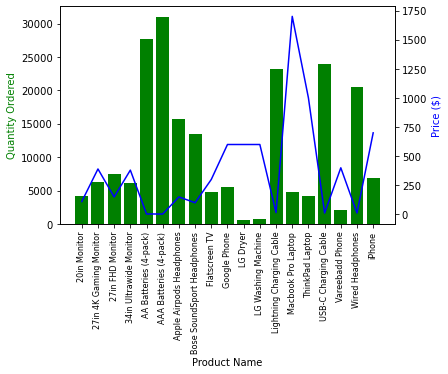

In [33]:
keys = [pair for pair, df in df.groupby('Product')]
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.bar(keys, products, color='g')
ax2.plot(keys, prices, color='b')

ax1.set_xlabel('Product Name')
ax1.set_ylabel('Quantity Ordered', color='g')
ax2.set_ylabel('Price ($)', color='b')
ax1.set_xticklabels(keys, rotation=90, size=8)

fig.show()